C:\Users\Lucas\Downloads\x_train.txt -> True
C:\Users\Lucas\Downloads\y_train.txt -> True
C:\Users\Lucas\Downloads\x_test.txt -> True
Séparateur détecté pour x_train: ','
Colonnes xtrain: ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7', 'VOLUME_7'] ... 46
Colonnes xtest : ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7', 'VOLUME_7'] ... 46
Colonnes ytrain_df: ['RET']
Avertissement: SECTOR/DATE/RET1 manquants, agrégat non créé.
Features initiales: [] ... total=0
Fallback features: ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_

C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy(LogReg): 0.505
Accuracy(RandomForest): 1.000


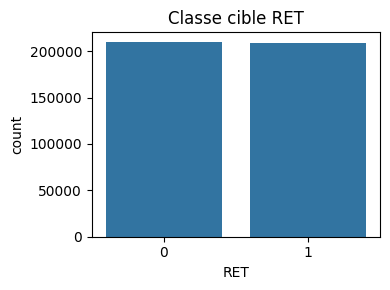

<Figure size 400x300 with 0 Axes>

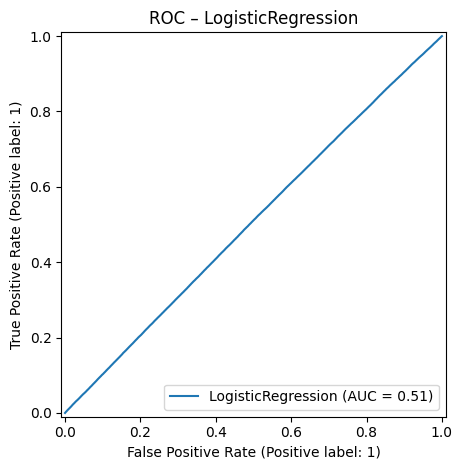

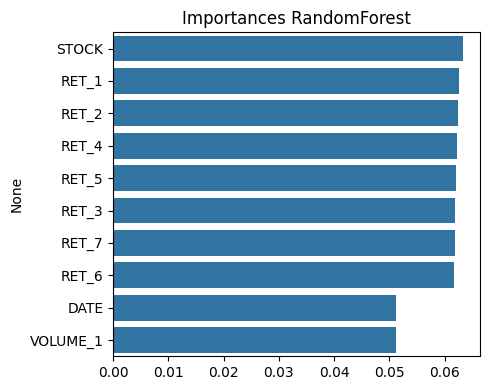

Soumission écrite: C:\Users\Lucas\Downloads\submission_baseline.csv


In [1]:
# -*- coding: utf-8 -*-
# QRT baseline robuste pour fichiers .txt dans Downloads

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, RocCurveDisplay

# -----------------------------------------------
# Chemins vers les fichiers .txt
XTRAIN = Path(r"C:\Users\Lucas\Downloads\x_train.txt")
YTRAIN = Path(r"C:\Users\Lucas\Downloads\y_train.txt")
XTEST  = Path(r"C:\Users\Lucas\Downloads\x_test.txt")

for f in [XTRAIN, YTRAIN, XTEST]:
    print(f, "->", f.exists())

# -----------------------------------------------
# Devine le séparateur à partir de la première ligne
with open(XTRAIN, encoding="utf8") as fh:
    first_line = fh.readline()
sep = "," if first_line.count(",") >= first_line.count("\t") else "\t"
print("Séparateur détecté pour x_train:", repr(sep))

# Lecture avec index "ID" si présent; sinon, on le fixe après
xtrain = pd.read_csv(XTRAIN, sep=sep)
ytrain_df = pd.read_csv(YTRAIN, sep=sep)
xtest  = pd.read_csv(XTEST,  sep=sep)

# Assurer présence de la colonne ID en index si existante
if "ID" in xtrain.columns:
    xtrain = xtrain.set_index("ID")
if "ID" in xtest.columns:
    xtest = xtest.set_index("ID")
if "ID" in ytrain_df.columns:
    ytrain_df = ytrain_df.set_index("ID")

print("Colonnes xtrain:", list(xtrain.columns)[:20], "...", len(xtrain.columns))
print("Colonnes xtest :", list(xtest.columns)[:20], "...", len(xtest.columns))
print("Colonnes ytrain_df:", list(ytrain_df.columns))

# Cible: première colonne si "RET" non présent
target_col = "RET" if "RET" in ytrain_df.columns else ytrain_df.columns[0]
ytrain = ytrain_df[target_col].rename("RET").astype(int)

# Optionnel: mapping des noms si nécessaire (adapter selon tes entêtes réelles)
mapcols = {
    # "Id":"ID", "Date":"DATE", "Secteur":"SECTOR", "Ret_1":"RET1", ...
}
xtrain = xtrain.rename(columns=mapcols)
xtest  = xtest.rename(columns=mapcols)

# -----------------------------------------------
# Liste de features cibles (si dispo)
all_feats = [f"RET{i}" for i in range(1,21)] + [f"VOLUME{i}" for i in range(1,21)] + ["SECTOR","DATE"]
present = [c for c in all_feats if c in xtrain.columns]
extra_feats = []

# Agrégat SECTOR/DATE si possible
if {"SECTOR","DATE","RET1"}.issubset(xtrain.columns):
    grp = (
        xtrain.reset_index()
              .groupby(["SECTOR","DATE"])["RET1"]
              .mean()
              .rename("MEAN_RET1_SECTOR_DATE")
              .reset_index()
    )
    train_fe = (
        xtrain.reset_index()
              .merge(grp, on=["SECTOR","DATE"], how="left")
              .set_index("ID")
    )
    test_fe = (
        xtest.reset_index()
             .merge(grp, on=["SECTOR","DATE"], how="left")
             .set_index("ID")
    )
    extra_feats = ["MEAN_RET1_SECTOR_DATE"]
else:
    train_fe, test_fe = xtrain, xtest
    print("Avertissement: SECTOR/DATE/RET1 manquants, agrégat non créé.")

# Features de travail prioritaire
feats = [f for f in present if f.startswith("RET") or f.startswith("VOLUME")] + extra_feats
feats = [c for c in feats if c in train_fe.columns]
print("Features initiales:", feats[:20], f"... total={len(feats)}")

# -----------------------------------------------
# Correctif: fallback et conversion numérique
if len(feats) == 0:
    # Prendre colonnes numériques disponibles
    num_cols = train_fe.select_dtypes(include=["number"]).columns.tolist()
    num_cols = [c for c in num_cols if c != "RET"]
    feats = num_cols[:20]
    print("Fallback features:", feats)

Xtr = train_fe[feats].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(np.float64)
Xte = test_fe[feats].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(np.float64)

assert Xtr.shape[1] > 0 and Xtr.shape[0] > 0, "Aucune feature exploitable trouvée."
print("Xtr shape:", Xtr.shape)

# -----------------------------------------------
# Modèles
logreg = LogisticRegression(max_iter=300, random_state=0)
logreg.fit(Xtr, ytrain)
proba_log = logreg.predict_proba(Xtr)[:,1]
acc_log = accuracy_score(ytrain, (proba_log >= 0.5).astype(int))

rf = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1)
rf.fit(Xtr, ytrain)
proba_rf = rf.predict_proba(Xtr)[:,1]
acc_rf = accuracy_score(ytrain, (proba_rf >= 0.5).astype(int))

print(f"Accuracy(LogReg): {acc_log:.3f}")
print(f"Accuracy(RandomForest): {acc_rf:.3f}")

# -----------------------------------------------
# Plots
plt.figure(figsize=(4,3))
sns.countplot(x=ytrain)
plt.title("Classe cible RET")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
RocCurveDisplay.from_estimator(logreg, Xtr, ytrain)
plt.title("ROC – LogisticRegression")
plt.tight_layout()
plt.show()

if len(feats) >= 5:
    imp = pd.Series(rf.feature_importances_, index=feats).sort_values(ascending=False).head(10)
    plt.figure(figsize=(5,4))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title("Importances RandomForest")
    plt.tight_layout()
    plt.show()

if "DATE" in xtrain.columns and "RET1" in xtrain.columns:
    daily = xtrain.groupby("DATE")["RET1"].mean().reset_index()
    plt.figure(figsize=(6,3))
    sns.lineplot(data=daily, x="DATE", y="RET1")
    plt.title("Moyenne RET1 par DATE")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# Soumission
sub = pd.Series(rf.predict_proba(Xte)[:,1], index=Xte.index, name="target")
out = XTEST.parent / "submission_baseline.csv"
sub.to_csv(out)
print("Soumission écrite:", out)
